# Assignment 6 - Recognizing objects in images with deep learning

## Goals

In this assignment you will get to know the main ingredients of deep learning and get started using the GPUs available in the Big Data Lab.

You'll learn to use

 * tensors
 * automatic differentiation
 * layered learners
 * p(re)trained networks for image classification.

## Check the GPU setup

When you are logged in to a lab machine, run ``nvidia-smi`` to see the available card and its memory usage.

```
$ nvidia-smi
Mon Feb  5 08:03:15 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.12                 Driver Version: 390.12                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 105...  Off  | 00000000:01:00.0  On |                  N/A |
| 45%   24C    P8    N/A /  75W |   3087MiB /  4038MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU       PID   Type   Process name                             Usage      |
|=============================================================================|
|    0      3627      G   /usr/lib/xorg/Xorg                           169MiB |
|    0     10843      C   ...d/CMPT/big-data/tmp_py/dlenv/bin/python  2897MiB |
+-----------------------------------------------------------------------------+
```

This shows that the machine has an **NVIDIA GTX 1050 with 4G of RAM**. Also, you can see that I'm running a process (pid=10843) that currently takes up close to 3 GB of GPU memory.

```
$ pstree -ls 10843
screen───bash───jupyter-noteboo───python─┬─4*[python]
                                         └─26*[{python}]
```
Inside a terminal window you may use ``who``, ``ps -aux | less``, or ``pstree -ls <PID>`` as above to find out who is using the shared resources. In my case, it turns out that I'm running a jupyter notebook related to process 10843. Halting the notebook frees up the GPU memory. 

## PyTorch setup in the lab

In the following we are going to use **[pytorch](http://pytorch.org)**, which received some praise recently for being faster than [tensorflow](http://tensorflow.org) and for also having a nice high-level API as NN modules that are similar to [Keras](https://keras.io/).

The default `conda` environment has pytorch 1.0 installed. This means, you should be able to use it without any changes to your environment.

### Use our downloaded pre-built models
To save disk space in your home folder, we recommend that you let pytorch use the pre-built models that we already downloaded for you (about 1.6G):
```
mkdir -p ~/.torch/models
ln -s /usr/shared/CMPT/big-data/dot_torch_shared/models/models/* ~/.torch/models
```

## Learn about Pytorch usage

To familiarize yourself with PyTorch, have a look at the [Examples](http://pytorch.org/tutorials/beginner/pytorch_with_examples.html) or briefly skim over the [60 min blitz tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html).

# Task 1: Finding rectangles

A nice blog-post by [Johannes Rieke](https://towardsdatascience.com/object-detection-with-neural-networks-a4e2c46b4491) presents a simple setup from scratch that finds rectangles in a black & white image. In order to play with it, we just have to translate a few calls from Keras to PyTorch.

**Here is an example of the training data:**

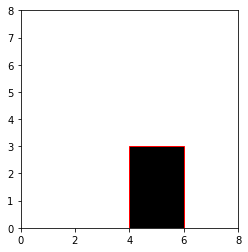

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display, Markdown

%matplotlib inline

# Create images with random rectangles and bounding boxes. 
num_imgs = 50000

img_size = 8
min_object_size = 1
max_object_size = 4
num_objects = 1

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))  # set background to 0

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        w, h = np.random.randint(min_object_size, max_object_size, size=2)
        x = np.random.randint(0, img_size - w)
        y = np.random.randint(0, img_size - h)
        imgs[i_img, x:x+w, y:y+h] = 1.  # set rectangle to 1
        bboxes[i_img, i_object] = [x, y, w, h]
        
imgs.shape, bboxes.shape

display(Markdown('**Here is an example of the training data:**'))
i = 0
plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
for bbox in bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))

In [2]:
# Reshape and normalize the image data to mean 0 and std 1. 
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

# Normalize x, y, w, h by img_size, so that all values are between 0 and 1.
# Important: Do not shift to negative values (e.g. by setting to mean 0), because the IOU calculation needs positive w and h.
y = bboxes.reshape(num_imgs, -1) / img_size
y.shape, np.mean(y), np.std(y)

# Split training and test.
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

## Task 1a
Construct a Pytorch model that resembles the Keras one in the original blog post, i.e. have a fully connected, hidden layer with 200 neurons, ReLU nonlinearity and dropout rate of 20%.

In [3]:
## According to the blog post

inp = X.shape[-1]
out = y.shape[-1]
hidden = 200
model =  torch.nn.Sequential(torch.nn.Linear(inp, hidden),
                             torch.nn.ReLU(),
                             torch.nn.Dropout(0.20),
                             torch.nn.Linear(hidden, out))

In [4]:
optimizer = torch.optim.Adadelta(model.parameters())
loss_fn = torch.nn.MSELoss(size_average=False)

/opt/anaconda3/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [5]:
inputs = Variable(torch.Tensor(train_X))
labels = Variable(torch.Tensor(train_y))

In [6]:
phase = 'train'
running_loss = 0.0
running_corrects = 0

loss_record = []
for epoch in range(30):
    optimizer.zero_grad()

    outputs = model(inputs)

    loss = loss_fn(outputs, labels)

    if phase == 'train':
        loss.backward()
        optimizer.step()

    running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / inputs.shape[0] / (epoch+1)
    loss_record.append(epoch_loss)

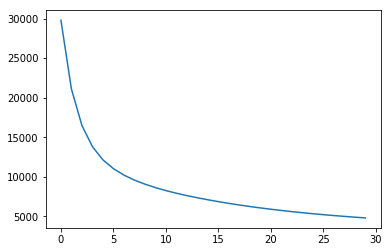

In [7]:
plt.plot(loss_record)

In [8]:
# Predict bounding boxes on the test images.
model = model.eval()
pred_y = model(Variable(torch.Tensor(test_X)))
pred_bboxes = pred_y.data * img_size
pred_bboxes = pred_bboxes.numpy().reshape(len(pred_bboxes), num_objects, -1)
pred_bboxes.shape

(10000, 1, 4)

In [9]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I
    U = w1 * h1 + w2 * h2 - I
    return I / U

0.40677860011350375

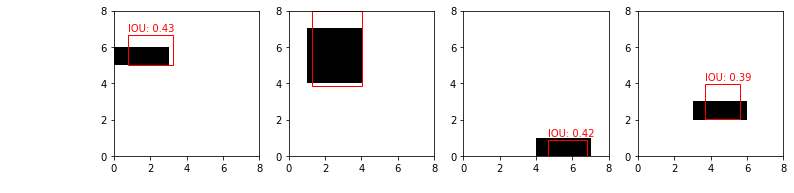

In [10]:
# Show a few images and predicted bounding boxes from the test dataset. 
plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_imgs))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))
        plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.2), color='r')
# Calculate the mean IOU (overlap) between the predicted and expected bounding boxes on the test dataset. 
summed_IOU = 0.
for pred_bbox, test_bbox in zip(pred_bboxes.reshape(-1, 4), test_bboxes.reshape(-1, 4)):
    summed_IOU += IOU(pred_bbox, test_bbox)
mean_IOU = summed_IOU / len(pred_bboxes)
mean_IOU

## Task 1b:
Move the computation that is currently done on the CPU over to the GPU using CUDA and increase the number of epochs. Improve the training setup until you reach an IOU of above 0.6.
You can make the changes that move computation to the GPU directly in the cells above.

In [11]:
### Computing on GPU
### To compute on the GPU the general rule to follow is to use .cuda() with your tensor and models. 
### Try to find out Variable wrapper and model in the above code and add .cuda() to it

inp = X.shape[-1]
out = y.shape[-1]
hidden = 200

model =  torch.nn.Sequential(torch.nn.Linear(inp, hidden),
                             torch.nn.ReLU(),
                             torch.nn.Dropout(0.20),
                             torch.nn.Linear(hidden ,out),
                             ).cuda()


optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss(size_average=False)

inputs = Variable(torch.cuda.FloatTensor(train_X))
labels = Variable(torch.cuda.FloatTensor(train_y))

phase = 'train'
running_loss = 0.0
running_corrects = 0

loss_record = []
for epoch in range(5000):
    optimizer.zero_grad()

    outputs = model(inputs)

    loss = loss_fn(outputs, labels)

    if phase == 'train':
        loss.backward()
        optimizer.step()

    running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / inputs.shape[0] / (epoch+1)
    loss_record.append(epoch_loss)

/opt/anaconda3/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


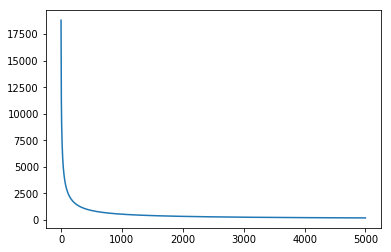

In [12]:
plt.plot(loss_record)

In [13]:
# Predict bounding boxes on the test images.
model = model.eval()
pred_y = model(Variable(torch.cuda.FloatTensor(test_X)))
pred_bboxes = pred_y.data * img_size
pred_bboxes = pred_bboxes.cpu().numpy().reshape(len(pred_bboxes), num_objects, -1)
pred_bboxes.shape

(10000, 1, 4)

In [14]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I
    U = w1 * h1 + w2 * h2 - I
    return I / U

0.9364044069144991

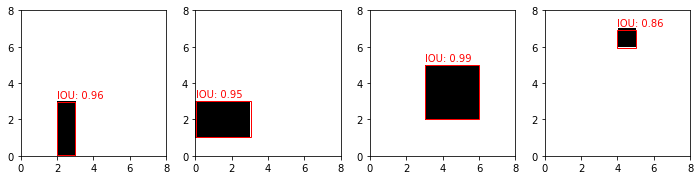

In [15]:
# Show a few images and predicted bounding boxes from the test dataset. 
plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_imgs))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))
        plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.2), color='r')
# Calculate the mean IOU (overlap) between the predicted and expected bounding boxes on the test dataset. 
summed_IOU = 0.
for pred_bbox, test_bbox in zip(pred_bboxes.reshape(-1, 4), test_bboxes.reshape(-1, 4)):
    summed_IOU += IOU(pred_bbox, test_bbox)
mean_IOU = summed_IOU / len(pred_bboxes)
mean_IOU

# Task 2: Use a pretrained model

As mentioned in class deep learning systems are hardly ever developed from scratch, but usually work by refining existing solutions to similar problems. For the following task, we'll work through the 
[Transfer learning tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html), which also provides a ready-made jupyter notebook.

 1. Download the notebook and get it to run in your environment. This also involves downloading the bees and ants dataset.
 2. Perform your own training with the provided setup.Copy the relevant code into this notebook, as mentioned in the submission instructions.
 3. Change the currently chosen pretrained network (resnet) to a different one. At least try out VGG and one other type.
 4. Load a picture that you took yourself and classify it with an unmodified pretrained network (e.g. the original VGG network) that can detect one out of 1000 classes. Display the image and class label in the notebook for submission.

### Hints for step 3

Focus on the section **Conv net as fixed feature xtractor** of the transfer learning tutorial.
First, change the line
```
model_conv = torchvision.models.resnet18(pretrained=True)
```
to load VGG19 instead.

Next, print out the new model_conv and identify the last step of the classification. This is not named the same way as the ```fc``` layer for resnet, but works similarily. Identify the module that contains the last classification step of the VGG model, which identifies one out of 1000 classes. Change that one into identifying 2 classes only (i.e. the ants and bees that you should start with).

To change the structure of Sequential component called ```module_name``` and to modify its last layer into a DifferentLayer type, you can use this syntax.

```
nn.Sequential(*list(model_conv.module_name.children())[:-1] +
                     [nn.DifferentLayer(...)])
```
and replace the old model_conv.module_name with the differently structured version.

Task 2 Step 1 and 2: Download the notebook and get it to run in your environment. This also involves downloading the bees and ants dataset. Perform your own training with the provided setup.

## Submission

# TASK 2 PART 1 and 2

In [16]:
%matplotlib inline

Author: Sasank Chilamkurthy <https://chsasank.github.io>_

In this tutorial, you will learn how to train your network using transfer learning. You can read more about the transfer learning at cs231n
notes <https://cs231n.github.io/transfer-learning/>__

Quoting these notes,

In practice, very few people train an entire Convolutional Network
from scratch (with random initialization), because it is relatively
rare to have a dataset of sufficient size. Instead, it is common to
pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
contains 1.2 million images with 1000 categories), and then use the
ConvNet either as an initialization or a fixed feature extractor for
the task of interest.

These two major transfer learning scenarios look as follows:

    Finetuning the convnet: Instead of random initializaion, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.
    ConvNet as fixed feature extractor: Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.


In [17]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Load Data

We will use torchvision and torch.utils.data packages for loading the data.

The problem we're going to solve today is to train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.

.. Note :: Download the data from here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>_ and extract it to the current directory.



In [18]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images ^^^^^^^^^^^^^^^^^^^^^^ Let's visualize a few training images so as to understand the data augmentations.

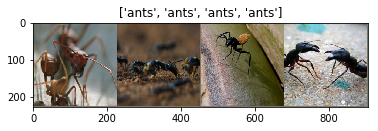

In [19]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model

Now, let's write a general function to train a model. Here, we will illustrate:

    Scheduling the learning rate
    Saving the best model

In the following, parameter scheduler is an LR scheduler object from torch.optim.lr_scheduler.


In [20]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images


In [21]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet

Load a pretrained model and reset final fully connected layer.


In [22]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate ^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.


In [23]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5034 Acc: 0.7418
val Loss: 0.2071 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.5196 Acc: 0.7828
val Loss: 0.2366 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.5184 Acc: 0.8033
val Loss: 0.2504 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.3955 Acc: 0.8443
val Loss: 0.2083 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.4698 Acc: 0.8074
val Loss: 0.4132 Acc: 0.8562

Epoch 5/24
----------
train Loss: 0.4413 Acc: 0.7992
val Loss: 0.3270 Acc: 0.8954

Epoch 6/24
----------
train Loss: 0.4968 Acc: 0.7787
val Loss: 0.3673 Acc: 0.8824

Epoch 7/24
----------
train Loss: 0.3423 Acc: 0.8730
val Loss: 0.2368 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.3401 Acc: 0.8525
val Loss: 0.2459 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.2726 Acc: 0.8730
val Loss: 0.2579 Acc: 0.8954

Epoch 10/24
----------
train Loss: 0.2970 Acc: 0.8770
val Loss: 0.2336 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.3170 Acc: 0.8607
val Loss: 0.2498 Acc: 0.8889

Ep

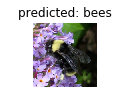

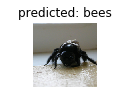

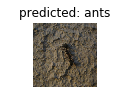

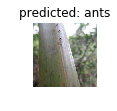

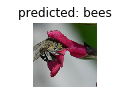

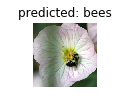

In [24]:
visualize_model(model_ft)

ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

You can read more about this in the documentation here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>__.


In [25]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate ^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario. This is expected as gradients don't need to be computed for most of the network. However, forward does need to be computed.


In [26]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5955 Acc: 0.6639
val Loss: 0.3858 Acc: 0.8105

Epoch 1/24
----------
train Loss: 0.3990 Acc: 0.8197
val Loss: 0.2052 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.3930 Acc: 0.8197
val Loss: 0.1680 Acc: 0.9542

Epoch 3/24
----------
train Loss: 0.6530 Acc: 0.7295
val Loss: 0.1724 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.4680 Acc: 0.7951
val Loss: 0.1731 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.4707 Acc: 0.8074
val Loss: 0.2556 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.4307 Acc: 0.8156
val Loss: 0.2079 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.2764 Acc: 0.8934
val Loss: 0.1824 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.2982 Acc: 0.8811
val Loss: 0.1905 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3492 Acc: 0.8689
val Loss: 0.1906 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3086 Acc: 0.8934
val Loss: 0.2188 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.4637 Acc: 0.7951
val Loss: 0.1832 Acc: 0.9346

Ep

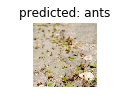

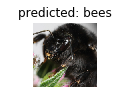

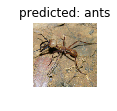

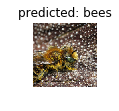

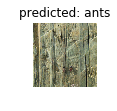

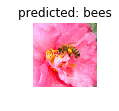

In [27]:
visualize_model(model_conv)

plt.ioff()
plt.show()

 # TASK 2 Part 3 : Change the currently chosen pretrained network (resnet) to a different one. At least try out VGG and one other type. I am going to use VGG and AlexNet


# ---------------------------------------------------VGG--------------------------------------------------------------------------------------

In [28]:
VGG_Net = torchvision.models.vgg19(pretrained = True)
for param in VGG_Net.parameters():
    param.requires_grad = False
    
VGG_Net.classifier = nn.Sequential(*list(VGG_Net.classifier.children())[:-1] +
                     [nn.Linear(4096,2)])

VGG_Net = VGG_Net.to(device)
                                      
criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(VGG_Net.classifier[6].parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [29]:
VGG_Net = train_model(VGG_Net, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.3068 Acc: 0.8484
val Loss: 0.1630 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.1951 Acc: 0.9385
val Loss: 0.1147 Acc: 0.9608

Epoch 2/24
----------
train Loss: 0.1263 Acc: 0.9467
val Loss: 0.1434 Acc: 0.9542

Epoch 3/24
----------
train Loss: 0.1519 Acc: 0.9262
val Loss: 0.1354 Acc: 0.9542

Epoch 4/24
----------
train Loss: 0.1046 Acc: 0.9713
val Loss: 0.1445 Acc: 0.9608

Epoch 5/24
----------
train Loss: 0.1531 Acc: 0.9549
val Loss: 0.1118 Acc: 0.9673

Epoch 6/24
----------
train Loss: 0.1589 Acc: 0.9385
val Loss: 0.0909 Acc: 0.9673

Epoch 7/24
----------
train Loss: 0.1331 Acc: 0.9631
val Loss: 0.0900 Acc: 0.9673

Epoch 8/24
----------
train Loss: 0.1711 Acc: 0.9426
val Loss: 0.0905 Acc: 0.9673

Epoch 9/24
----------
train Loss: 0.2168 Acc: 0.9426
val Loss: 0.0950 Acc: 0.9673

Epoch 10/24
----------
train Loss: 0.1299 Acc: 0.9631
val Loss: 0.0908 Acc: 0.9673

Epoch 11/24
----------
train Loss: 0.0615 Acc: 0.9795
val Loss: 0.0934 Acc: 0.9608

Ep

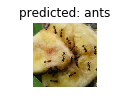

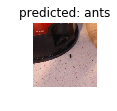

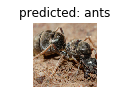

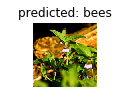

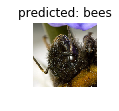

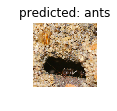

In [30]:
visualize_model(VGG_Net)

# --------------------------AlexNet---------------------------------------------------------------------

In [31]:
Alex_Net = torchvision.models.alexnet(pretrained = True)
for param in Alex_Net.parameters():
    param.require_grad = False
Alex_Net.classifier = nn.Sequential(*list(Alex_Net.classifier.children())[:-1] +
                     [nn.Linear(4096,2)])
Alex_Net = Alex_Net.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(Alex_Net.classifier[6].parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)        

In [32]:
Alex_Net = train_model(Alex_Net, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.9993 Acc: 0.7787
val Loss: 0.6913 Acc: 0.8889

Epoch 1/24
----------
train Loss: 1.1039 Acc: 0.8566
val Loss: 0.9415 Acc: 0.8758

Epoch 2/24
----------
train Loss: 0.6576 Acc: 0.9180
val Loss: 0.6787 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.4958 Acc: 0.9016
val Loss: 0.6642 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.3790 Acc: 0.9016
val Loss: 0.7253 Acc: 0.8824

Epoch 5/24
----------
train Loss: 0.4721 Acc: 0.9139
val Loss: 0.7407 Acc: 0.9085

Epoch 6/24
----------
train Loss: 0.6264 Acc: 0.9016
val Loss: 0.8634 Acc: 0.8954

Epoch 7/24
----------
train Loss: 0.2177 Acc: 0.9590
val Loss: 0.9160 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.2592 Acc: 0.9426
val Loss: 0.8671 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.1285 Acc: 0.9754
val Loss: 0.8586 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.2874 Acc: 0.9426
val Loss: 0.9006 Acc: 0.8954

Epoch 11/24
----------
train Loss: 0.2000 Acc: 0.9344
val Loss: 0.9713 Acc: 0.9020

Ep

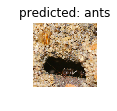

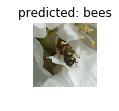

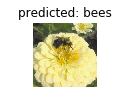

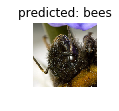

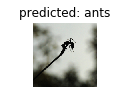

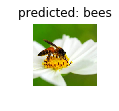

In [33]:
visualize_model(Alex_Net)

# TASK 2 PART 4: Load a picture that you took yourself and classify it with an unmodified pretrained network (e.g. the original VGG network) that can detect one out of 1000 classes. Display the image and class label in the notebook for submission.

screen, CRT screen


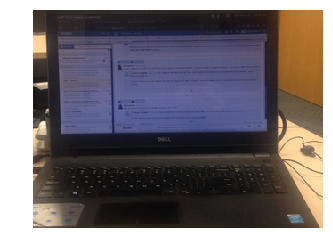

In [57]:
import io
import requests
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img=mpimg.imread('lap.jpg')
imgplot = plt.imshow(img)
imgplot = plt.axis('off')

def image_loader(loader, image_name):
    image = Image.open(image_name)
    image = loader(image).float()
    image = torch.tensor(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image

data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
labels = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}

model_ft = models.vgg19(pretrained=True)
model_ft.eval()
a = np.argmax(model_ft(image_loader(data_transforms, 'lap.jpg')).detach().numpy())
print(labels[a])

Looks like a good prediction.

For task 1 add your changes to the cells in this notebook.

For task 2 append the required fields of the the transfer learning tutorial to this notebook and make the required modifications. Ensure that you have clear section headings that show where you undertake which parts of the question.

Save this notebook containing all images and upload your submission as one [A6.ipynb](A6.ipynb) file.